In [ ]:
from google.colab import drive

drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
import cv2
import numpy as np
import glob
import matplotlib.pyplot as plt
import numpy as np
import os

In [ ]:
# Load all images
path_8x8 = "/content/drive/MyDrive/dataset/puzzle_8x8/*.jpg"
images_8x8 = sorted(glob.glob(path_8x8))

print(f"Total 8x8 images found: {len(images_8x8)}")

# Load images into memory
loaded_images = []
for img_path in images_8x8:
    img = cv2.imread(img_path)
    loaded_images.append(img)

print(f"✓ Loaded {len(loaded_images)} images")
print(f"Sample image shape: {loaded_images[0].shape}")

Total 8x8 images found: 110
✓ Loaded 110 images
Sample image shape: (224, 224, 3)


# **Final Pipeline** for 8x8 image
##Tiles_Extraction -> Gray Scaling -> Denoising -> Edge_Detection -> Contour Extraction-> Tiles_Stitching

#Extracting Tiles

In [ ]:
def extract_tiles_from_image(image, grid_size=(8, 8)):
    """Extract 64 tiles from one image"""
    height, width = image.shape[:2]
    rows, cols = grid_size

    piece_height = height // rows
    piece_width = width // cols

    tiles = []

    for row in range(rows):
        for col in range(cols):
            y1 = row * piece_height
            y2 = (row + 1) * piece_height
            x1 = col * piece_width
            x2 = (col + 1) * piece_width

            tile = image[y1:y2, x1:x2].copy()

            tiles.append({
                'tile': tile,
                'position': (row, col),
                'image_idx': 0  # Will be updated in loop
            })

    return tiles

# Extract tiles from all images
print("Extracting tiles from all images...")
all_tiles = []

for img_idx, img in enumerate(loaded_images):
    tiles = extract_tiles_from_image(img)

    # Update image index
    for tile_data in tiles:
        tile_data['image_idx'] = img_idx

    all_tiles.extend(tiles)

    if (img_idx + 1) % 10 == 0:
        print(f"  Processed {img_idx + 1}/{len(loaded_images)} images...")

print(f"\n✓ Total tiles extracted: {len(all_tiles)}")
print(f"✓ Expected: {len(loaded_images) * 64} tiles")

Extracting tiles from all images...
  Processed 10/110 images...
  Processed 20/110 images...
  Processed 30/110 images...
  Processed 40/110 images...
  Processed 50/110 images...
  Processed 60/110 images...
  Processed 70/110 images...
  Processed 80/110 images...
  Processed 90/110 images...
  Processed 100/110 images...
  Processed 110/110 images...

✓ Total tiles extracted: 7040
✓ Expected: 7040 tiles


## Visualizing tiles

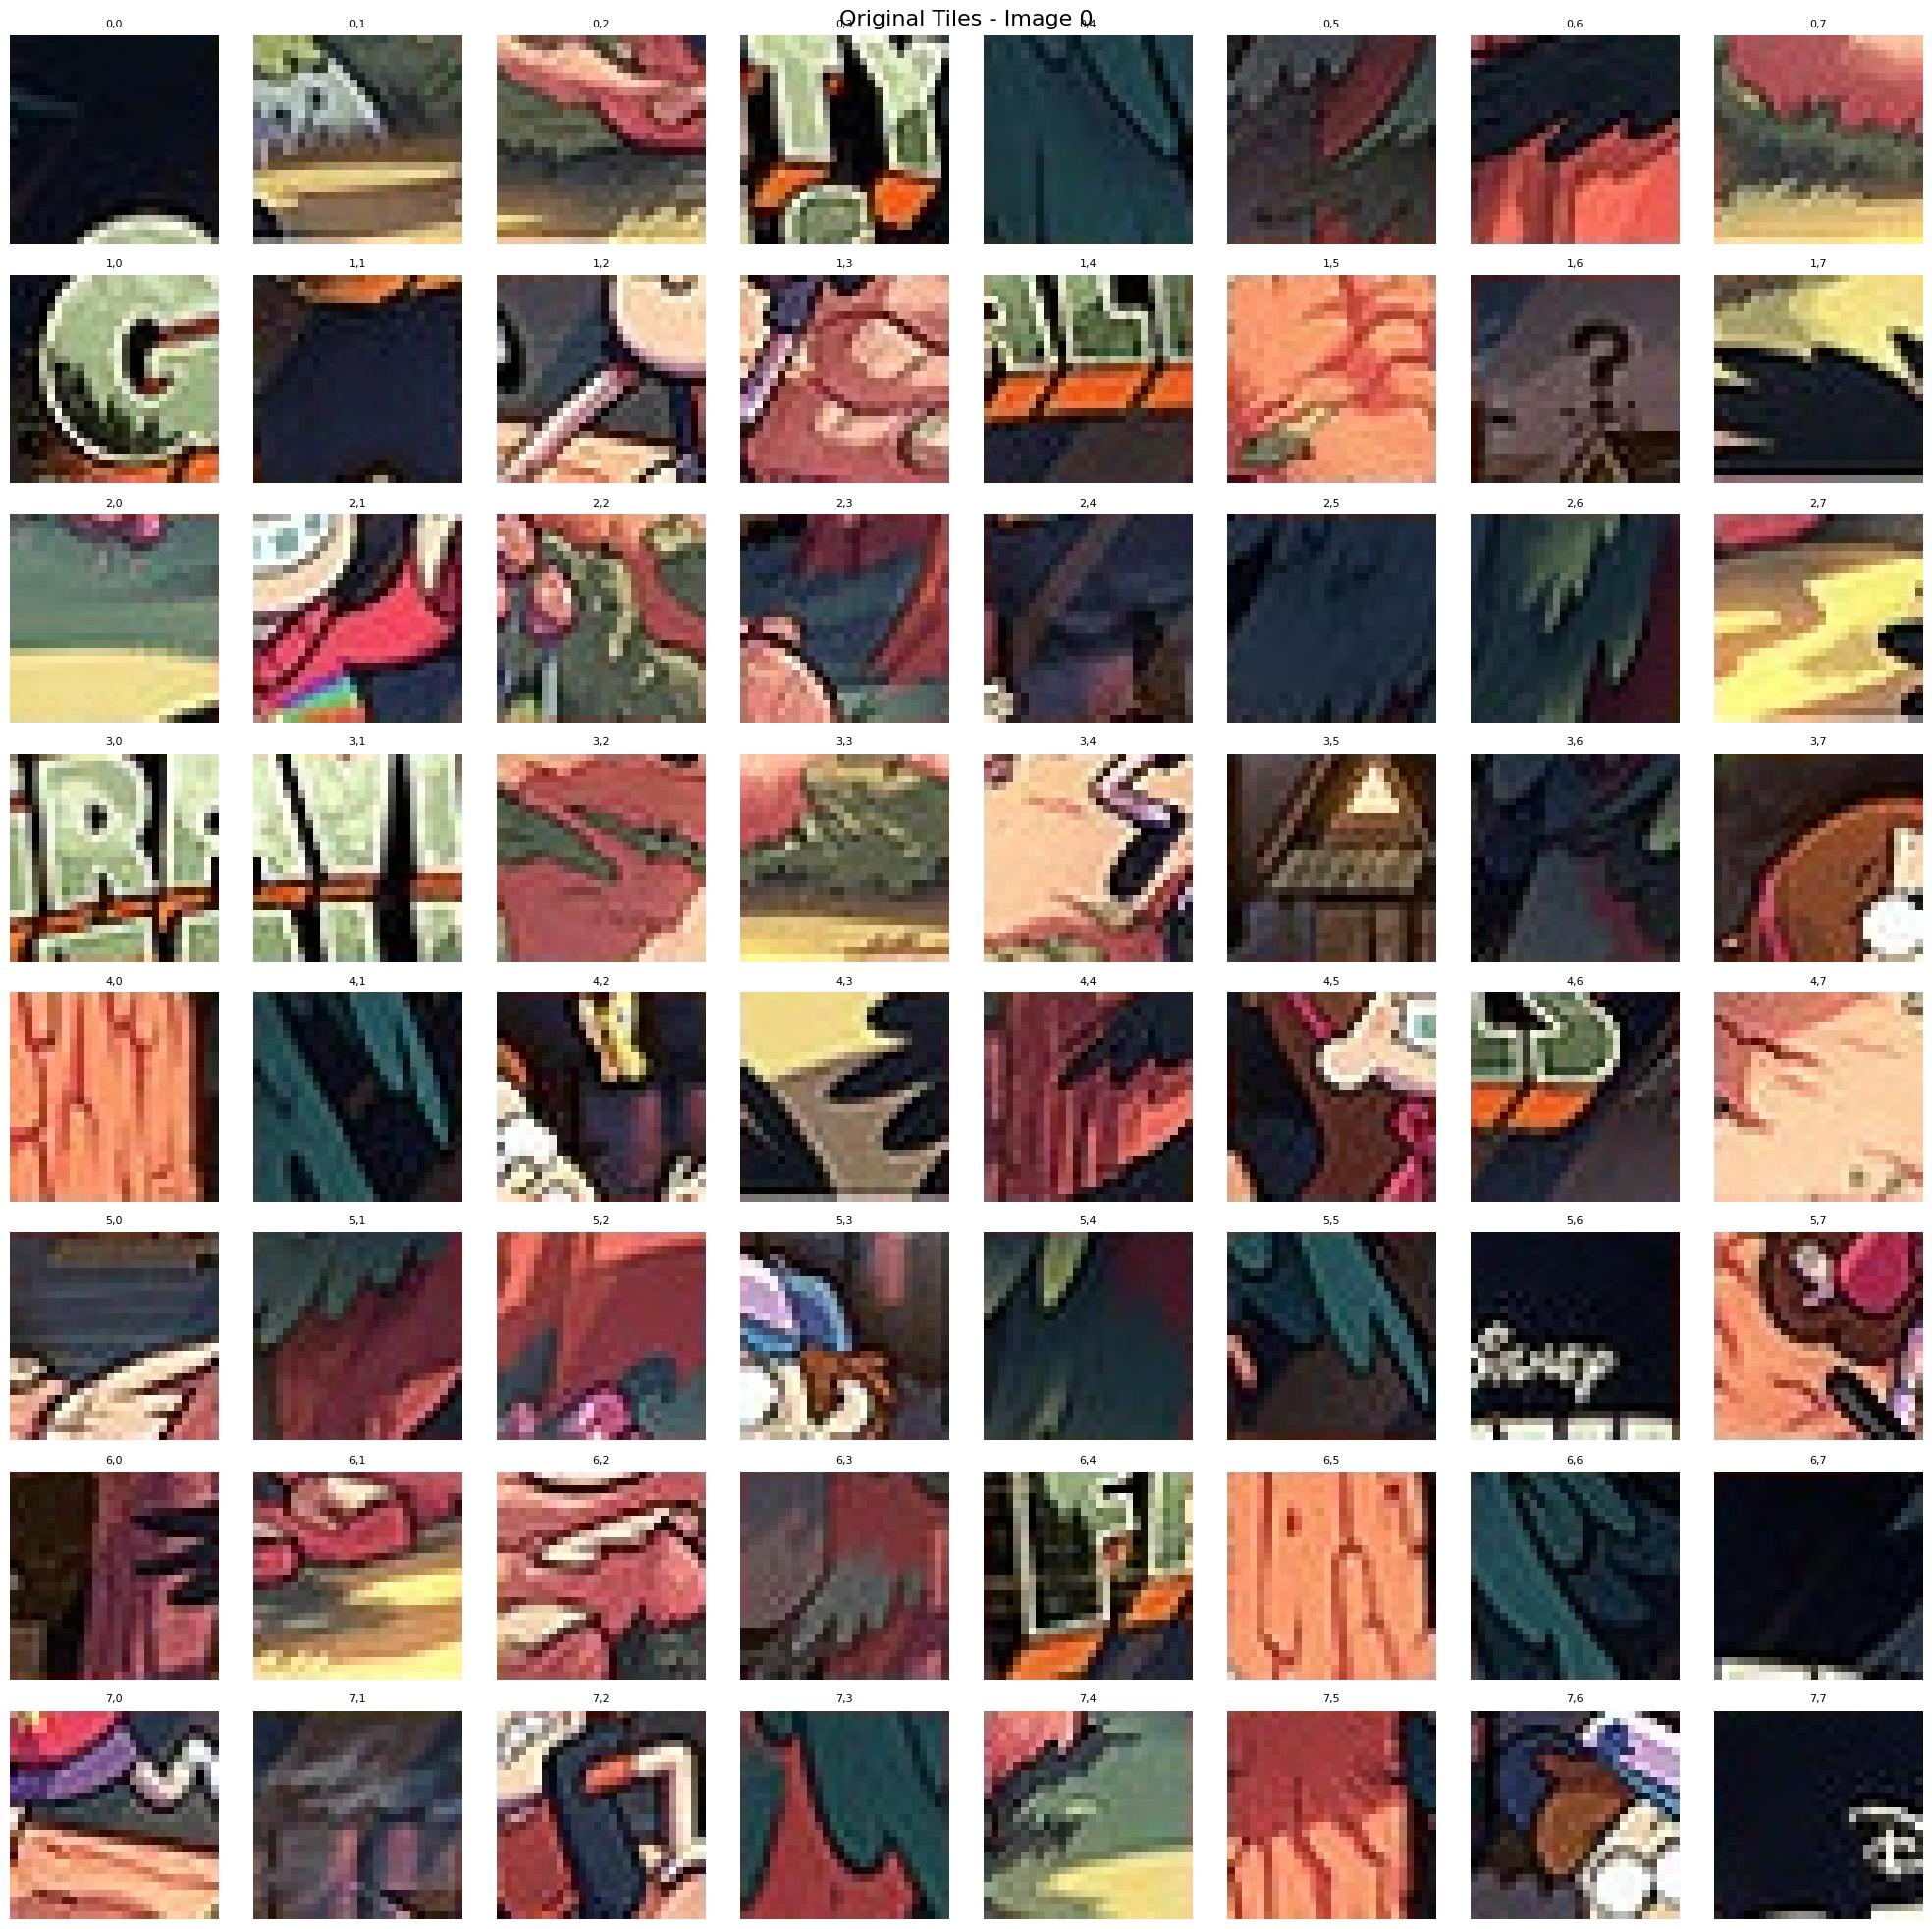

Showing 64 tiles from image 0


In [ ]:
# ==========================================
# VISUALIZE: SAMPLE ORIGINAL TILES
# ==========================================

# Show tiles from first image
sample_image_idx = 0
sample_tiles = [t for t in all_tiles if t['image_idx'] == sample_image_idx]

fig, axes = plt.subplots(8, 8, figsize=(20, 20))

for tile_data in sample_tiles[:64]:  # First 64 tiles
    row, col = tile_data['position']
    tile = tile_data['tile']

    axes[row, col].imshow(cv2.cvtColor(tile, cv2.COLOR_BGR2RGB))
    axes[row, col].set_title(f'{row},{col}', fontsize=8)
    axes[row, col].axis('off')

plt.suptitle(f'Original Tiles - Image {sample_image_idx}', fontsize=16)
plt.tight_layout()
plt.show()

print(f"Showing 64 tiles from image {sample_image_idx}")

# Gray Scaling

In [ ]:
# ==========================================
# STEP 1: GRAYSCALE CONVERSION
# ==========================================

print("Step 1: Converting all tiles to grayscale...")

for tile_data in all_tiles:
    tile = tile_data['tile']

    # Convert to grayscale
    if len(tile.shape) == 3:
        gray = cv2.cvtColor(tile, cv2.COLOR_BGR2GRAY)
    else:
        gray = tile.copy()

    # Store grayscale
    tile_data['gray'] = gray

print(f"✓ Converted {len(all_tiles)} tiles to grayscale")

Step 1: Converting all tiles to grayscale...
✓ Converted 7040 tiles to grayscale


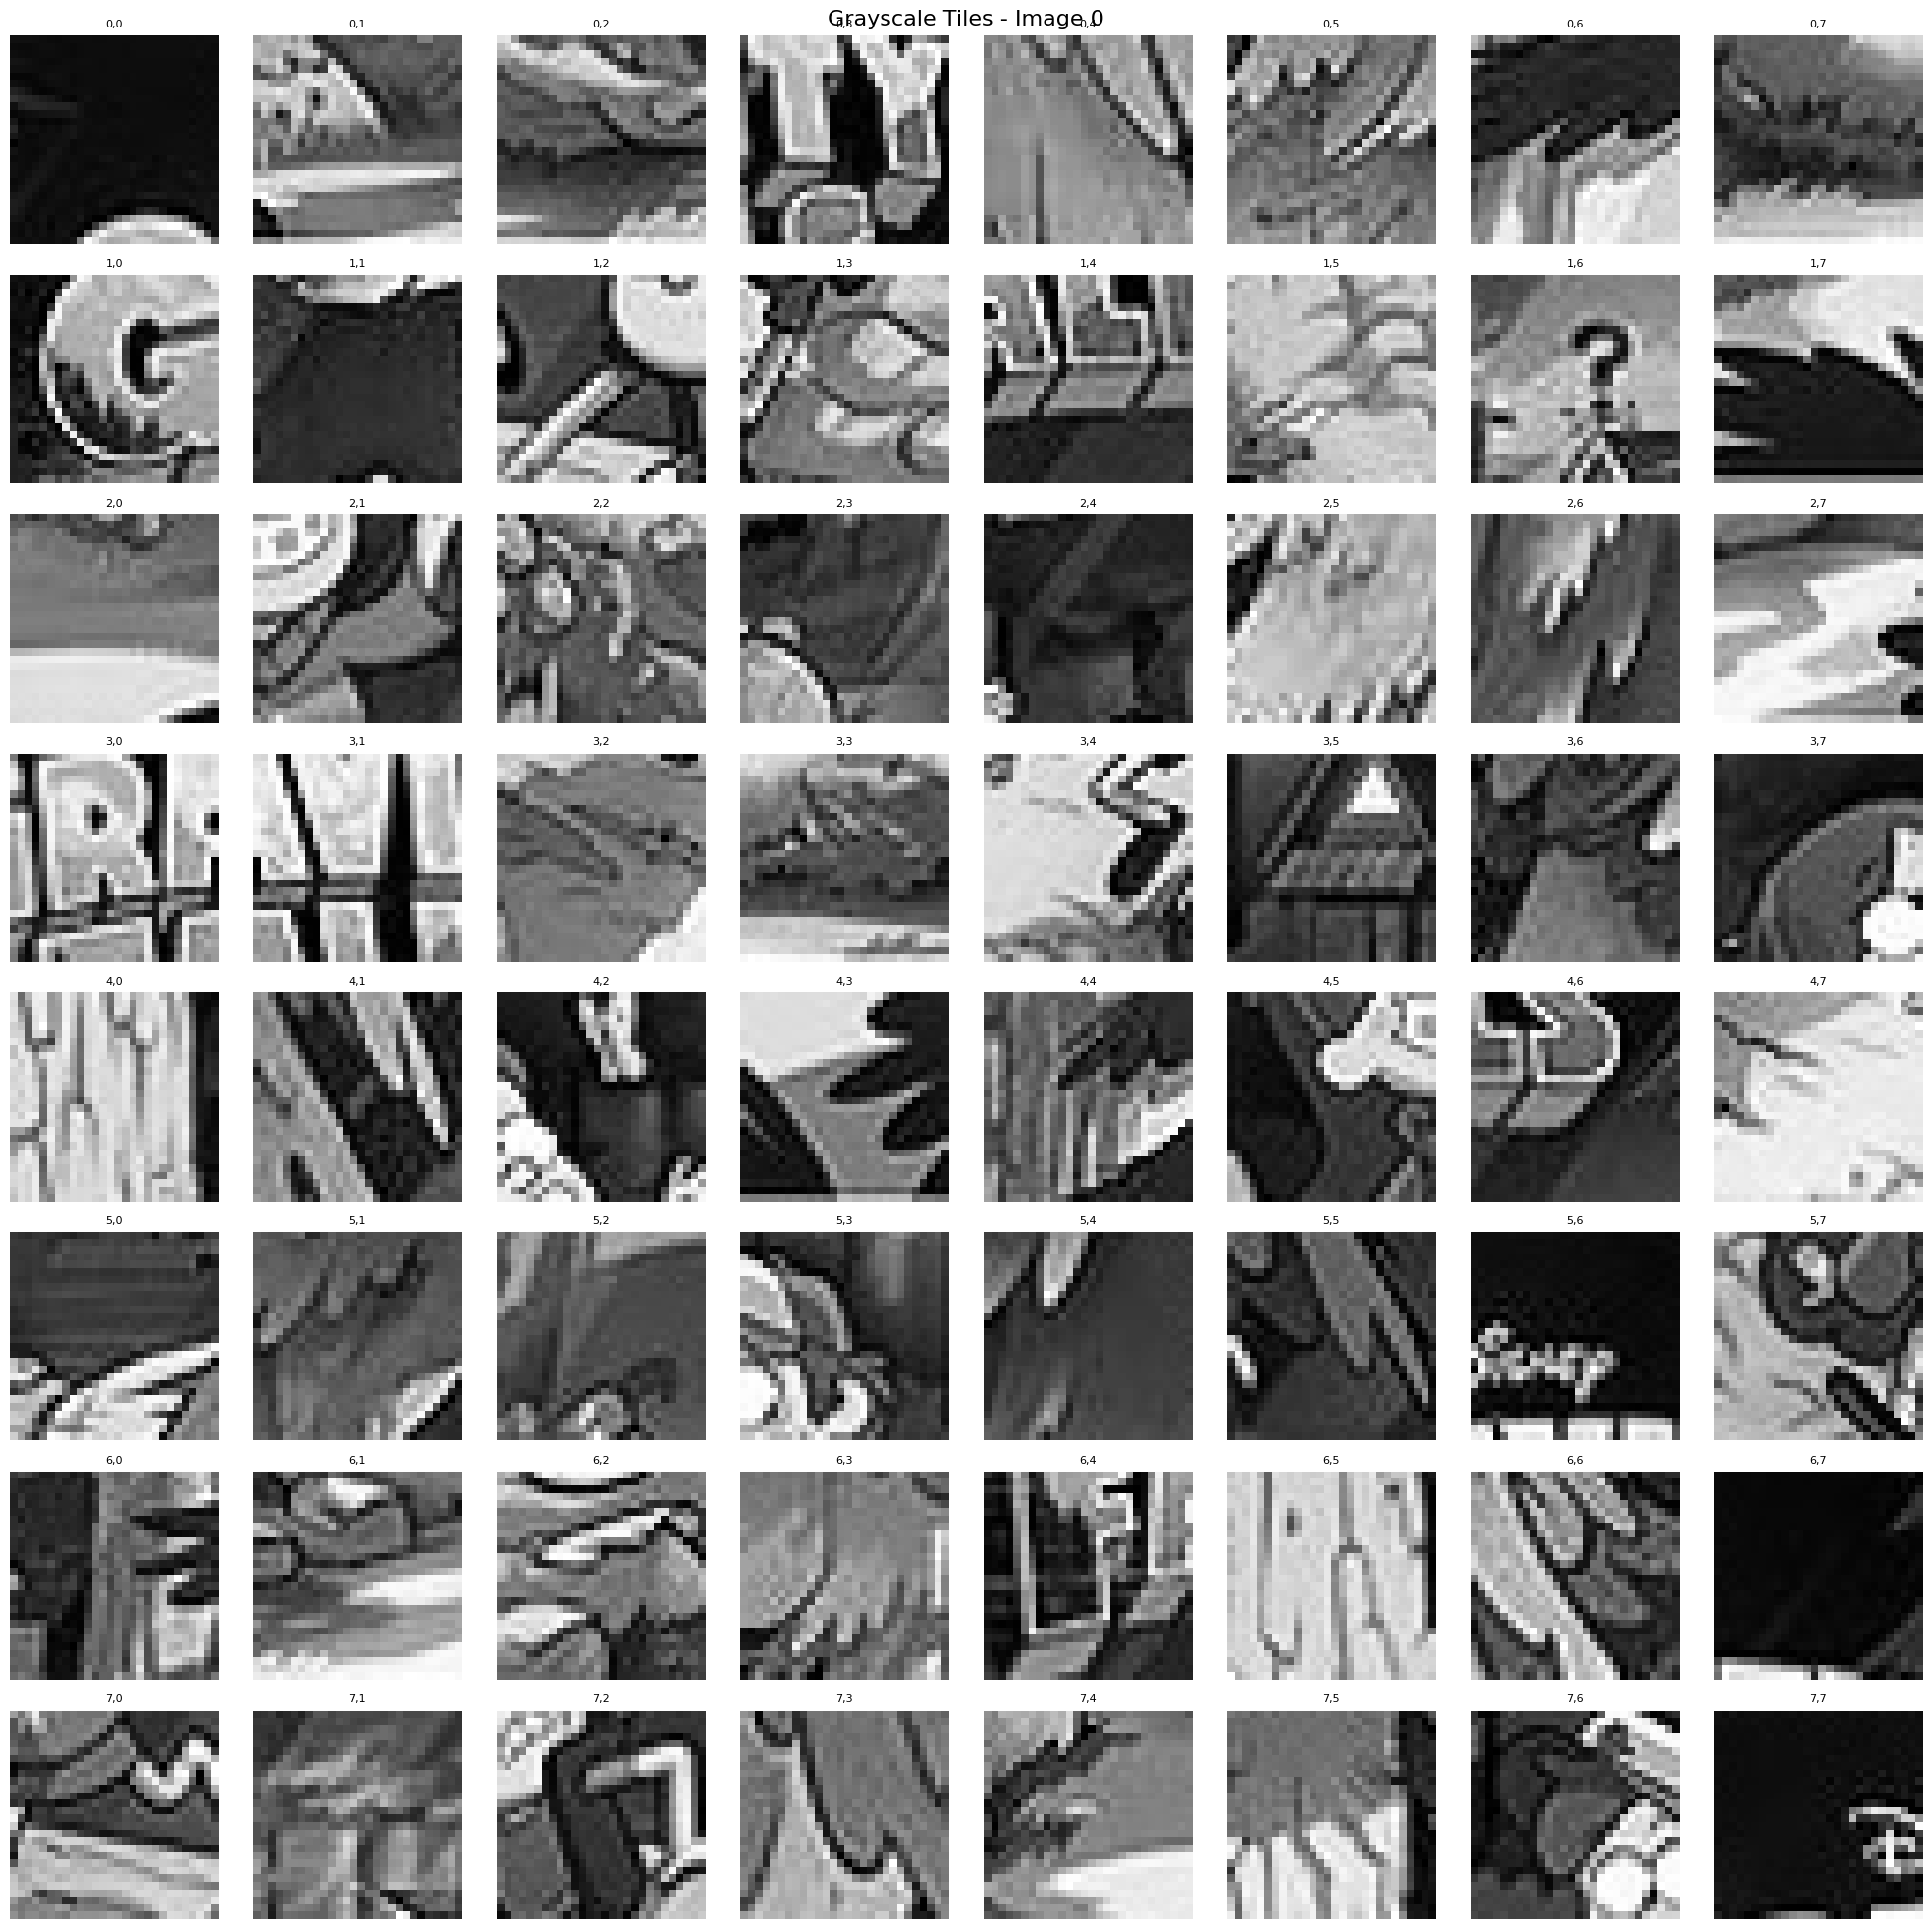

In [ ]:
# ==========================================
# VISUALIZE: GRAYSCALE TILES
# ==========================================

# Show grayscale tiles from first image
sample_tiles = [t for t in all_tiles if t['image_idx'] == 0]

fig, axes = plt.subplots(8, 8, figsize=(20, 20))

for tile_data in sample_tiles[:64]:
    row, col = tile_data['position']
    gray = tile_data['gray']

    axes[row, col].imshow(gray, cmap='gray')
    axes[row, col].set_title(f'{row},{col}', fontsize=8)
    axes[row, col].axis('off')

plt.suptitle('Grayscale Tiles - Image 0', fontsize=16)
plt.tight_layout()
plt.show()

# Denosing

In [ ]:
# ==========================================
# STEP 2: GAUSSIAN BLUR
# ==========================================

print("Step 2: Applying Gaussian blur to all tiles...")

kernel_size = (5, 5)

for tile_data in all_tiles:
    gray = tile_data['gray']

    # Apply Gaussian blur
    blurred = cv2.GaussianBlur(gray, kernel_size, 0)

    # Store blurred
    tile_data['blurred'] = blurred

print(f"✓ Applied Gaussian blur to {len(all_tiles)} tiles")

Step 2: Applying Gaussian blur to all tiles...
✓ Applied Gaussian blur to 7040 tiles


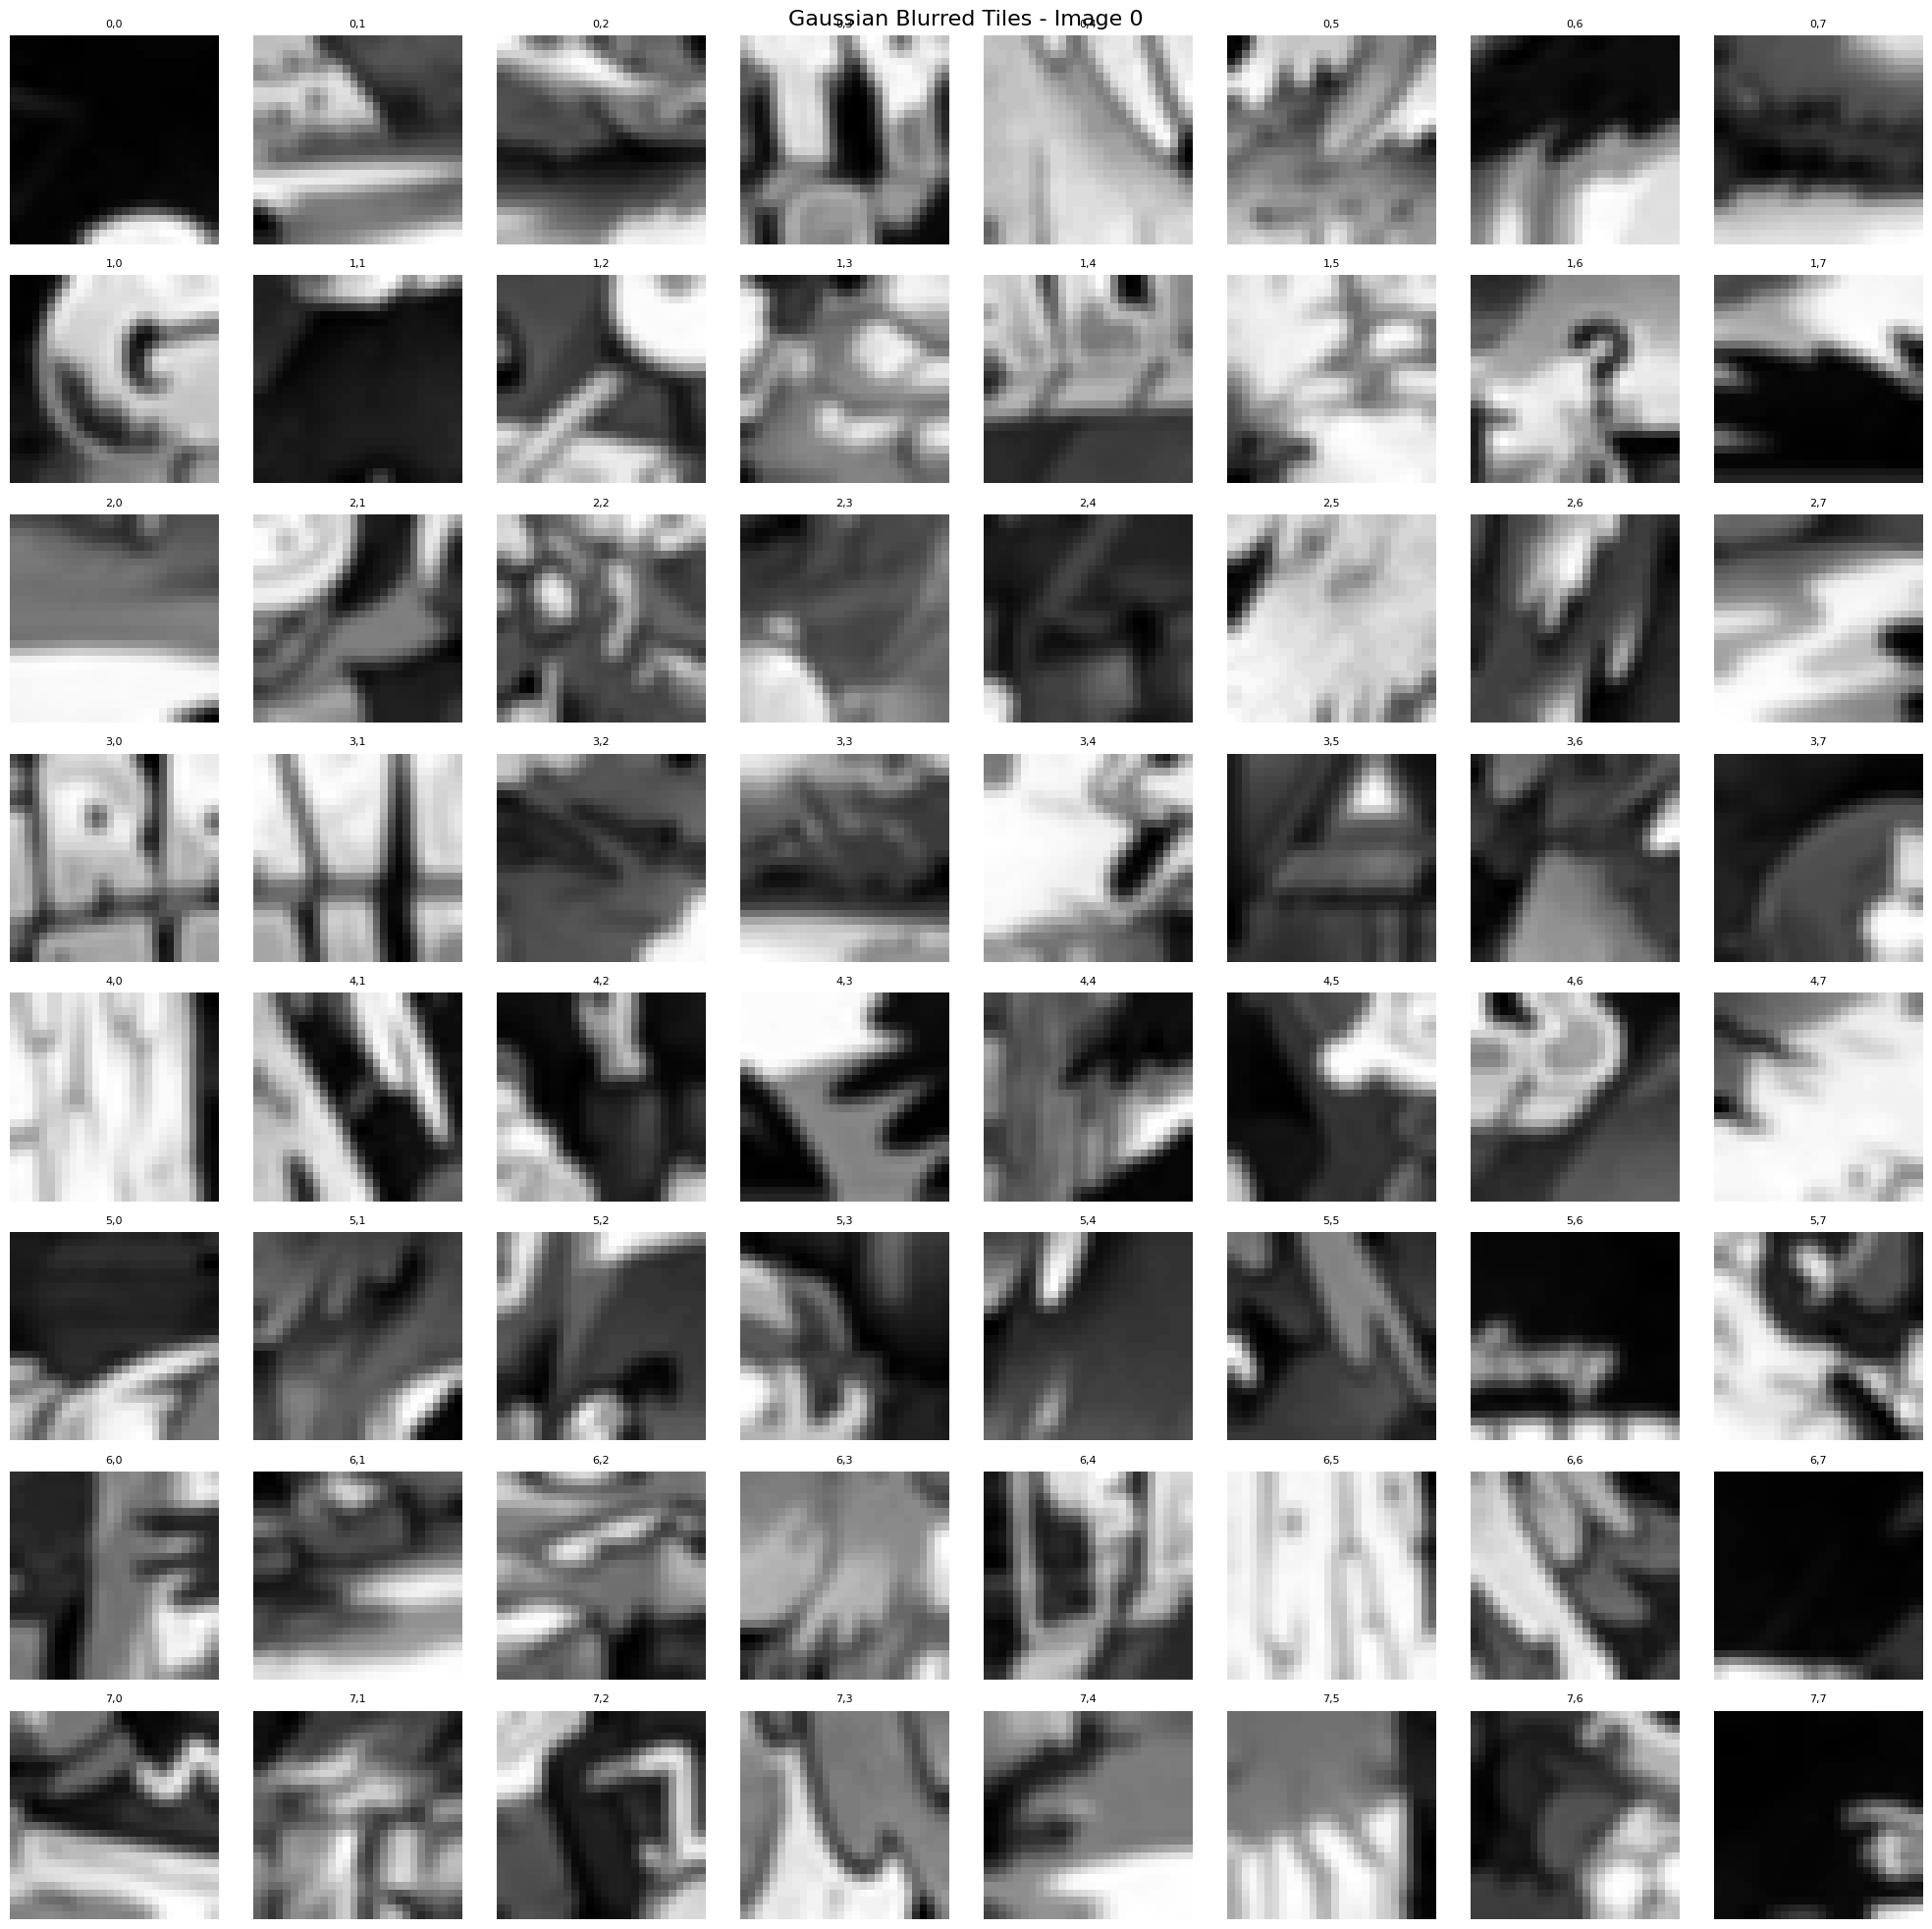

In [ ]:
# ==========================================
# VISUALIZE: BLURRED TILES
# ==========================================

sample_tiles = [t for t in all_tiles if t['image_idx'] == 0]

fig, axes = plt.subplots(8, 8, figsize=(20, 20))

for tile_data in sample_tiles[:64]:
    row, col = tile_data['position']
    blurred = tile_data['blurred']

    axes[row, col].imshow(blurred, cmap='gray')
    axes[row, col].set_title(f'{row},{col}', fontsize=8)
    axes[row, col].axis('off')

plt.suptitle('Gaussian Blurred Tiles - Image 0', fontsize=16)
plt.tight_layout()
plt.show()

# Canny Edge Detection

In [ ]:
# ==========================================
# STEP 3: CANNY EDGE DETECTION
# ==========================================

print("Step 3: Applying Canny edge detection to all tiles...")

for tile_data in all_tiles:
    blurred = tile_data['blurred']

    # Apply Canny edges instead of morphological gradient
    edges = cv2.Canny(blurred, 70, 200)   # <-- Your recommended thresholds

    # Store edges in place of gradient
    tile_data['gradient'] = edges   # keeping the SAME KEY so NO other code breaks

print(f"✓ Applied Canny to {len(all_tiles)} tiles")


Step 3: Applying Canny edge detection to all tiles...
✓ Applied Canny to 7040 tiles


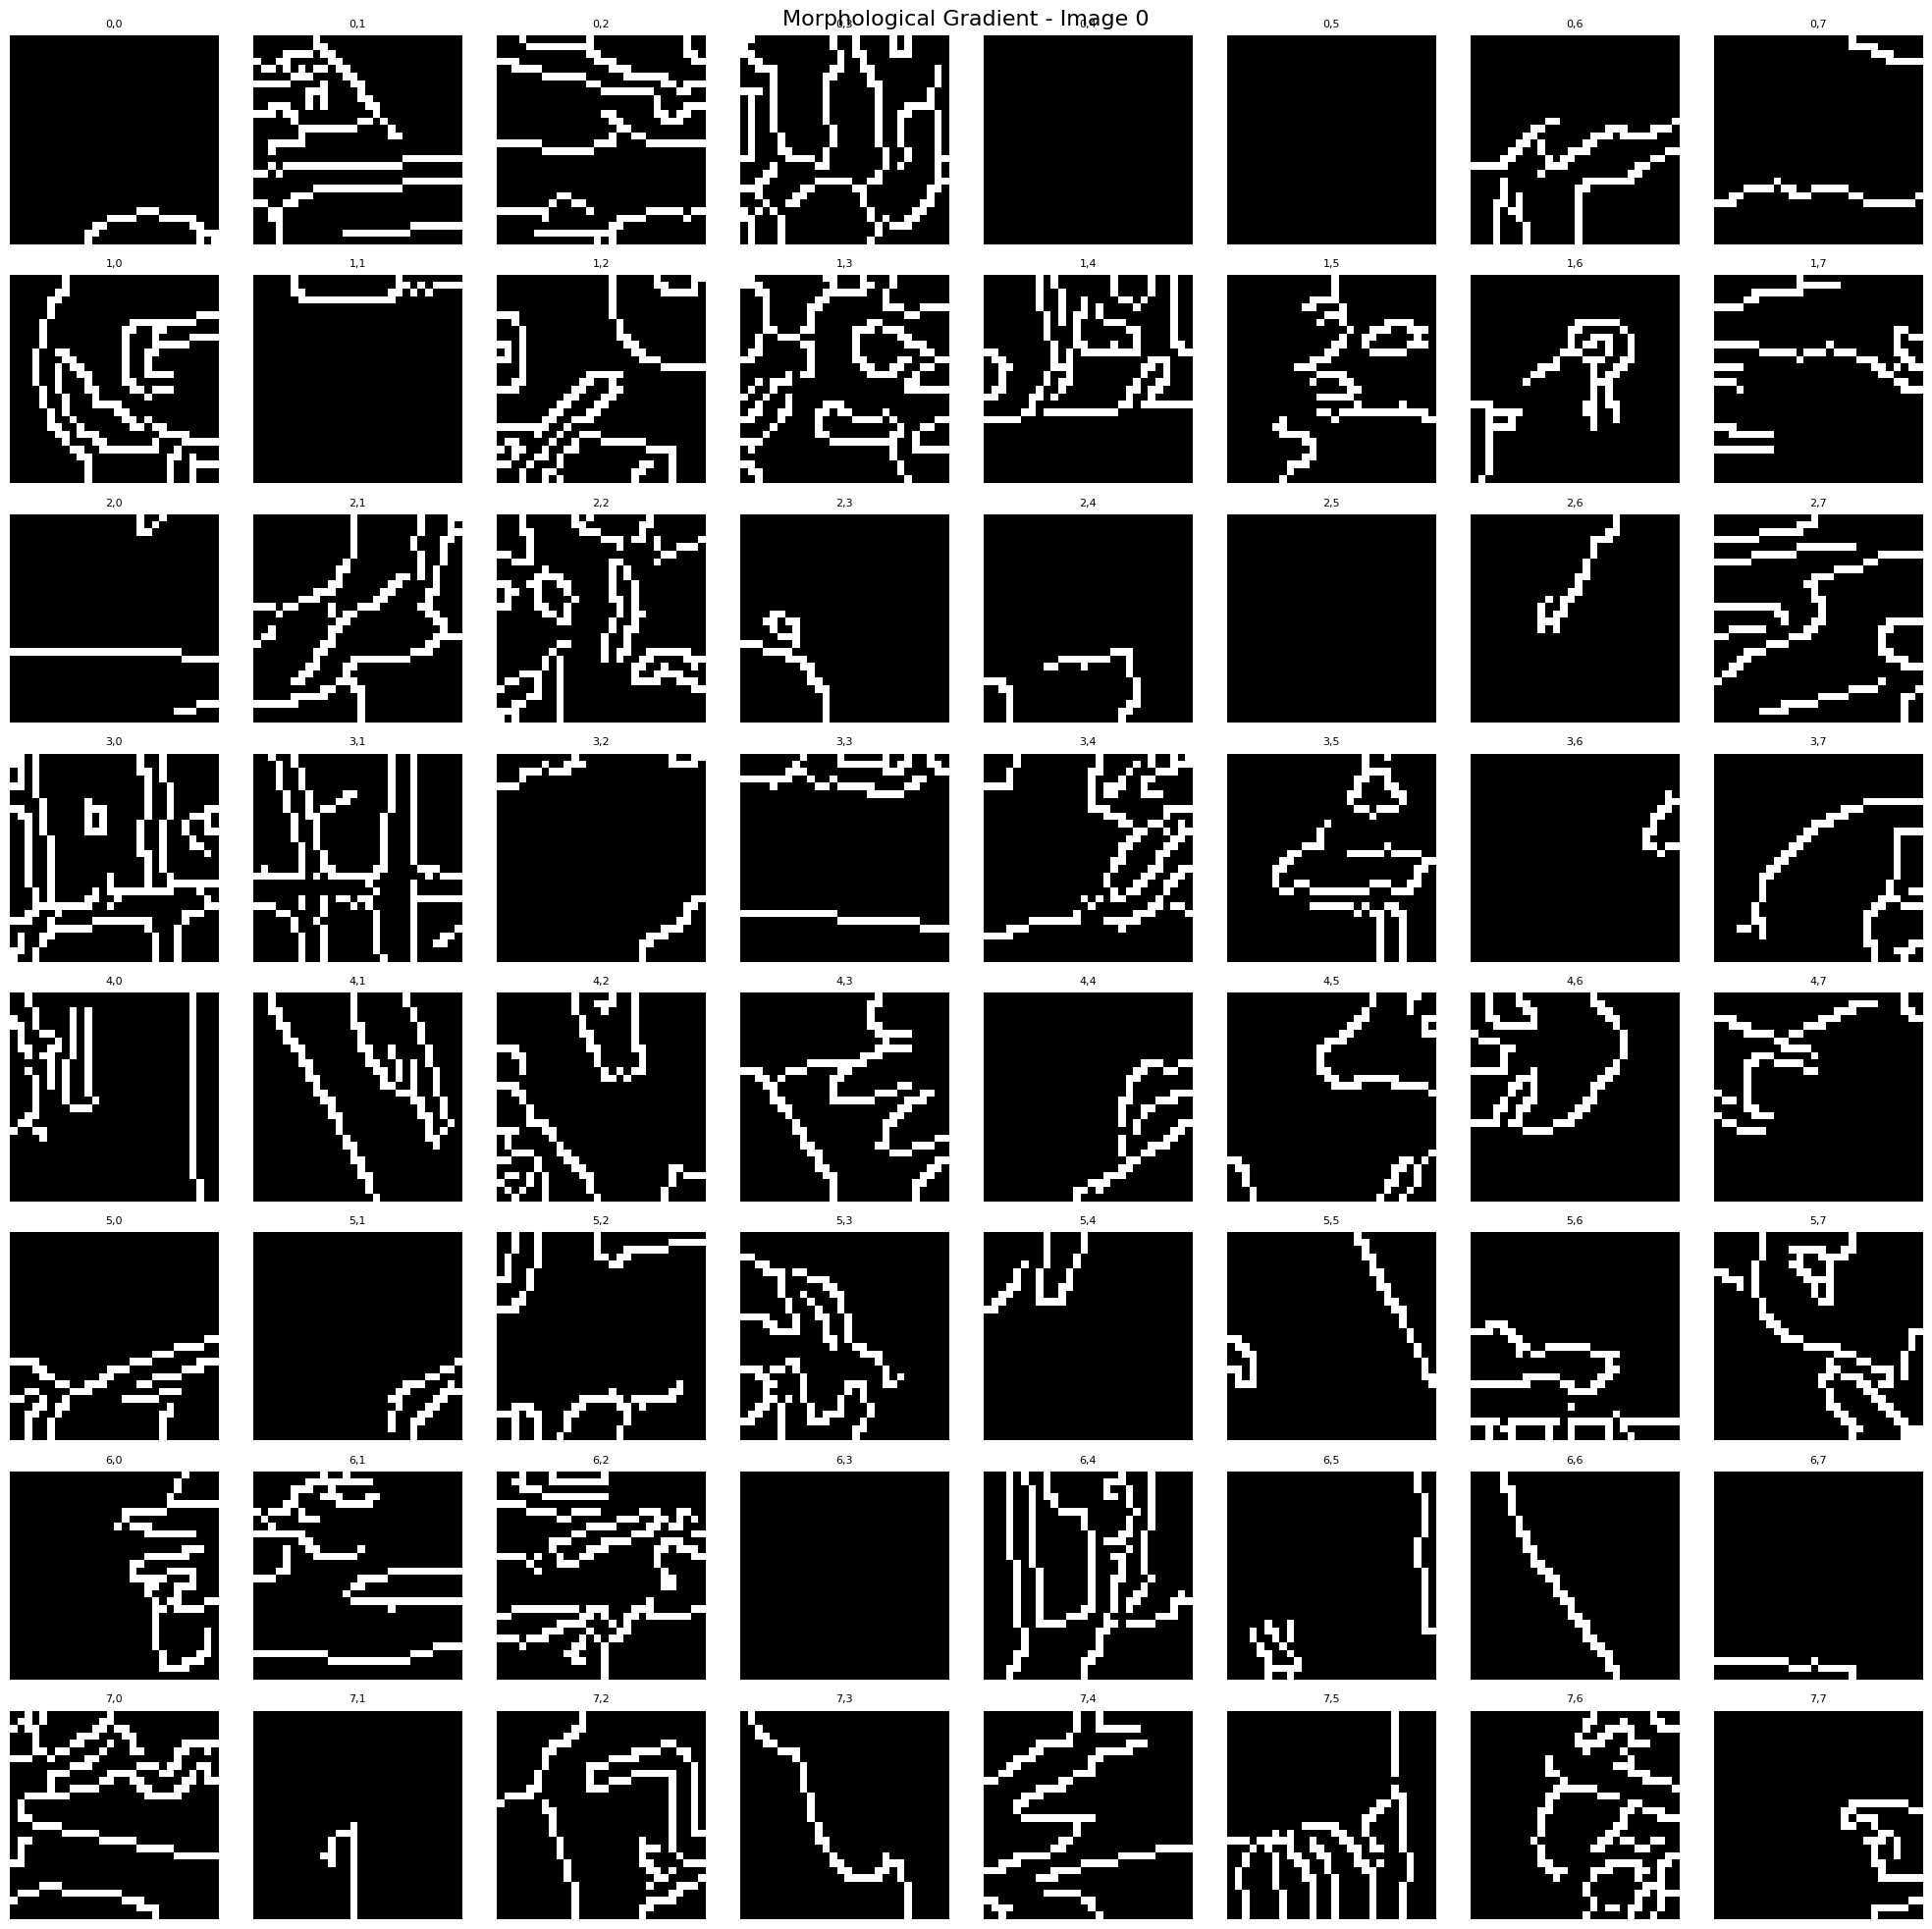

In [ ]:


sample_tiles = [t for t in all_tiles if t['image_idx'] == 0]

fig, axes = plt.subplots(8, 8, figsize=(20, 20))

for tile_data in sample_tiles[:64]:
    row, col = tile_data['position']
    gradient = tile_data['gradient']

    axes[row, col].imshow(gradient, cmap='gray')
    axes[row, col].set_title(f'{row},{col}', fontsize=8)
    axes[row, col].axis('off')

plt.suptitle('Canny - Image 0', fontsize=16)
plt.tight_layout()
plt.show()

#Closing

In [ ]:
# ==========================================
# STEP 4: MORPHOLOGICAL CLOSING
# ==========================================

print("Step 4: Applying morphological closing to all tiles...")

kernel = np.ones((3, 3), np.uint8)  # 3x3 square kernel; you can try 5x5 if edges are very broken

for tile_data in all_tiles:
    edges = tile_data['gradient']  # get the Canny edges

    # Apply morphological closing (dilation followed by erosion)
    closed_edges = cv2.morphologyEx(edges, cv2.MORPH_CLOSE, kernel)

    # Store back in the same key or create a new one if you want to keep both
    tile_data['gradient_closed'] = closed_edges

print(f"✓ Applied morphological closing to {len(all_tiles)} tiles")




Step 4: Applying morphological closing to all tiles...
✓ Applied morphological closing to 7040 tiles


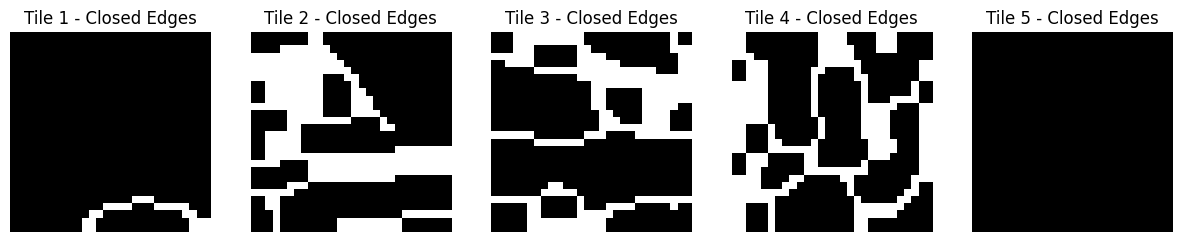

In [ ]:

num_tiles_to_show = min(5, len(all_tiles))  # show up to 5 tiles

plt.figure(figsize=(15, 5))

for i in range(num_tiles_to_show):
    closed_edges = all_tiles[i]['gradient_closed']

    plt.subplot(1, num_tiles_to_show, i + 1)
    plt.imshow(closed_edges, cmap='gray')
    plt.title(f'Tile {i+1} - Closed Edges')
    plt.axis('off')

plt.show()


# Contour Extraction and Visualization

In [ ]:

def visualize_image_tiles_with_contours(image_index, all_tiles, tiles_per_row=8):
    # Get the 64 tiles for this image
    start_idx = image_index * 64
    end_idx = start_idx + 64
    tiles = all_tiles[start_idx:end_idx]

    # Determine tile size (assuming all tiles same size)
    h, w = tiles[0]['blurred'].shape

    # Create an empty canvas for the whole image
    canvas = np.zeros((h * tiles_per_row, w * tiles_per_row, 3), dtype=np.uint8)

    for idx, tile_data in enumerate(tiles):
        closed_edges = tile_data['gradient_closed']
        original = tile_data['blurred']

        # Find contours
        contours, _ = cv2.findContours(closed_edges.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        # Draw contours on original tile (convert to BGR)
        tile_rgb = cv2.cvtColor(original, cv2.COLOR_GRAY2BGR)
        cv2.drawContours(tile_rgb, contours, -1, (0, 255, 0), 1)

        # Compute position in canvas
        row = idx // tiles_per_row
        col = idx % tiles_per_row
        canvas[row*h:(row+1)*h, col*w:(col+1)*w] = tile_rgb

    # Display
    plt.figure(figsize=(12, 12))
    plt.imshow(cv2.cvtColor(canvas, cv2.COLOR_BGR2RGB))
    plt.title(f'Image {image_index+1} - Contours on All 64 Tiles')
    plt.axis('off')
    plt.show()


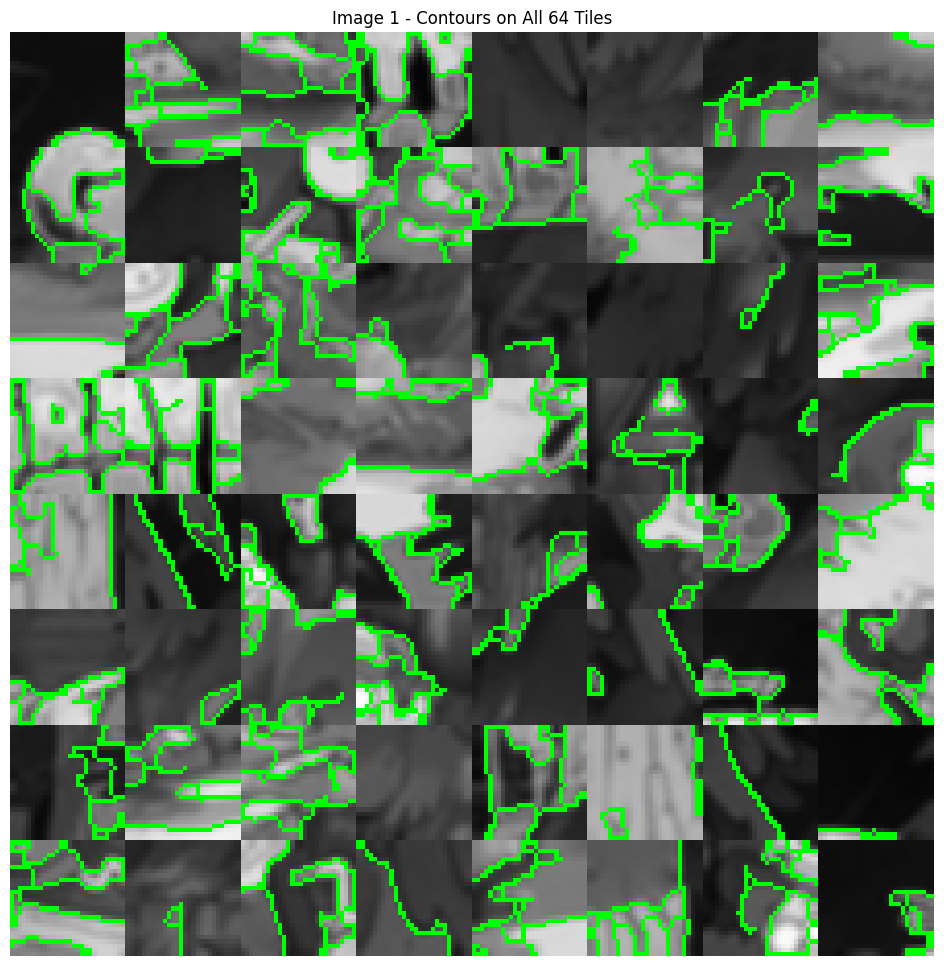

In [ ]:
visualize_image_tiles_with_contours(0, all_tiles)  # Image 1


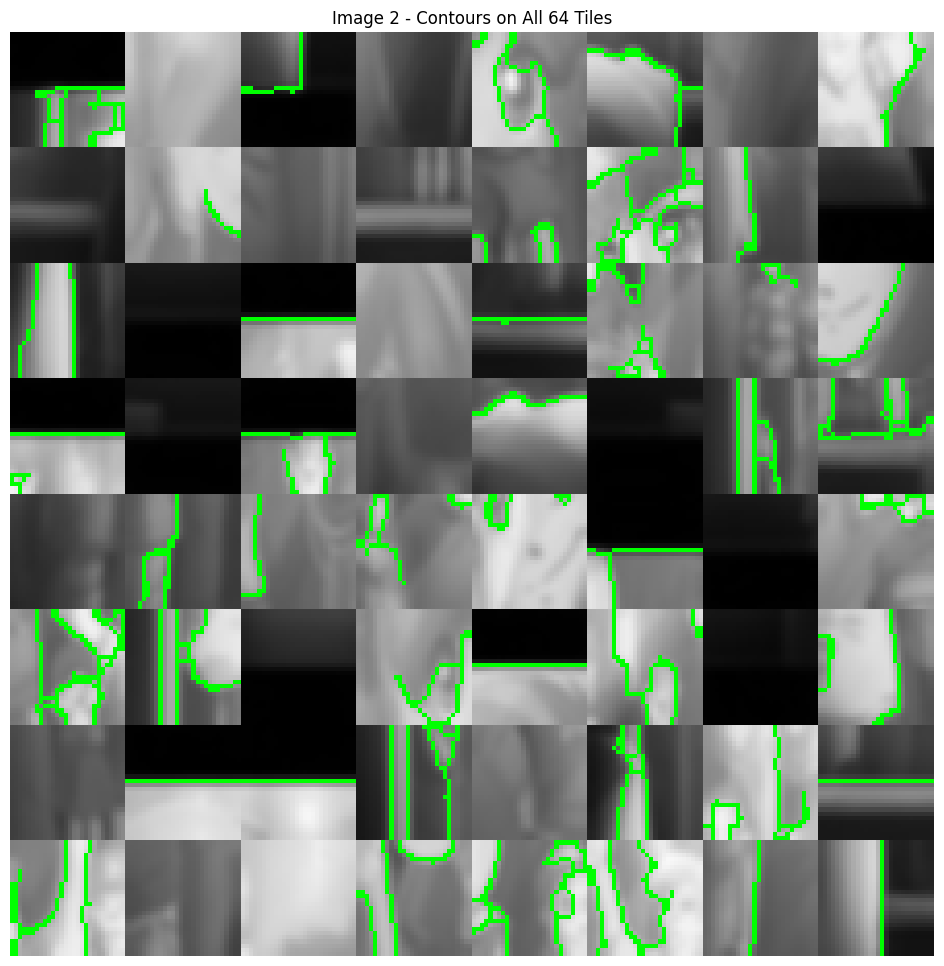

In [ ]:
visualize_image_tiles_with_contours(1, all_tiles)  # Image 2


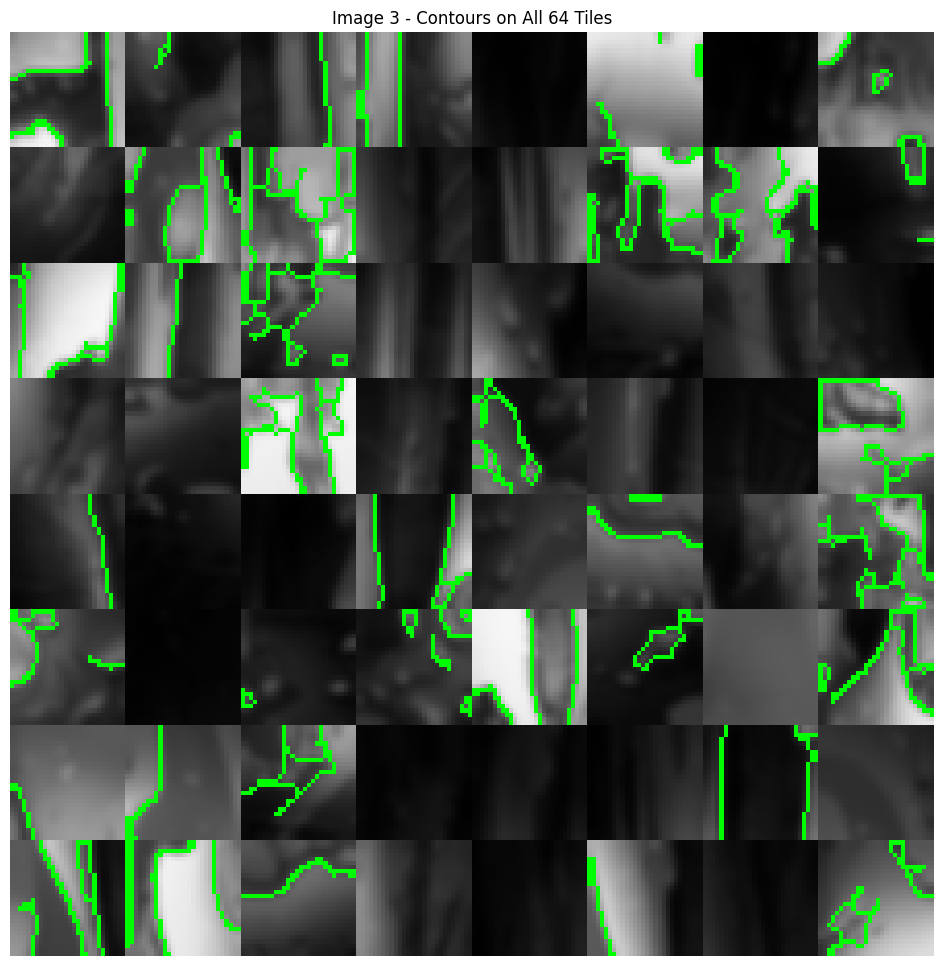

In [ ]:
visualize_image_tiles_with_contours(2, all_tiles)  # Image 2


# Stitching and saving images

In [ ]:
def save_pipeline_results_drive(all_tiles, output_base_path="/content/drive/MyDrive/image_processing/milestone1/results", tiles_per_image=64, tiles_per_row=8, save_tiles=True):
    """
    Saves stitched images and optionally individual tiles with contours to Google Drive.

    Parameters:
        all_tiles: list of dicts, each with 'blurred' and 'gradient_closed'
        output_base_path: base folder in Google Drive to save results
        tiles_per_image: number of tiles per original image (default 64)
        tiles_per_row: tiles per row in stitched image (default 8)
        save_tiles: whether to save individual tiles
    """
    # Create output folders
    stitched_path = os.path.join(output_base_path, "stitched")
    tiles_path = os.path.join(output_base_path, "tiles")
    os.makedirs(stitched_path, exist_ok=True)
    if save_tiles:
        os.makedirs(tiles_path, exist_ok=True)

    num_images = len(all_tiles) // tiles_per_image
    print(f"Saving results for {num_images} images in Drive...")

    for img_idx in range(num_images):
        start_idx = img_idx * tiles_per_image
        end_idx = start_idx + tiles_per_image
        tiles = all_tiles[start_idx:end_idx]

        h, w = tiles[0]['blurred'].shape
        canvas = np.zeros((h * tiles_per_row, w * tiles_per_row, 3), dtype=np.uint8)

        for idx, tile_data in enumerate(tiles):
            closed_edges = tile_data['gradient_closed']
            original = tile_data['blurred']

            # Find contours
            contours, _ = cv2.findContours(closed_edges.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

            # Draw contours on tile
            tile_rgb = cv2.cvtColor(original, cv2.COLOR_GRAY2BGR)
            cv2.drawContours(tile_rgb, contours, -1, (0, 255, 0), 1)

            # Place tile in stitched canvas
            row = idx // tiles_per_row
            col = idx % tiles_per_row
            canvas[row*h:(row+1)*h, col*w:(col+1)*w] = tile_rgb

            # Save individual tile
            if save_tiles:
                tile_file = os.path.join(tiles_path, f"image{img_idx+1}_tile{idx+1:02d}.png")
                cv2.imwrite(tile_file, cv2.cvtColor(tile_rgb, cv2.COLOR_RGB2BGR))

        # Save stitched image
        stitched_file = os.path.join(stitched_path, f"image{img_idx+1}_stitched.png")
        cv2.imwrite(stitched_file, cv2.cvtColor(canvas, cv2.COLOR_RGB2BGR))

    print(f"✓ All results saved to Google Drive at: {output_base_path}")

In [ ]:
save_pipeline_results_drive(all_tiles)


Saving results for 110 images in Drive...
✓ All results saved to Google Drive at: /content/drive/MyDrive/image_processing/milestone1/results


In [ ]:
!apt-get install git -y


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
git is already the newest version (1:2.34.1-1ubuntu1.15).
0 upgraded, 0 newly installed, 0 to remove and 41 not upgraded.


In [ ]:
!git config --global user.email "ali.ashraf.hamdy.5157@gmail.com"
!git config --global user.name "aliashrafhamdy5157"


In [ ]:
!git clone https://github.com/aliashrafhamdy5157/Image-Processing.git


Cloning into 'Image-Processing'...
fatal: could not read Username for 'https://github.com': No such device or address
